# Explore here

In [1]:
# Your code here

import pandas as pd

TARGET = "https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv"

df: pd.DataFrame = pd.read_csv(TARGET)
df.head()



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [2]:
if df.duplicated().sum() > 0:
    print("There are duplicated rows\n")
    df.drop_duplicates(inplace=True)
else:
    print("There are no duplicated rows\n")

There are no duplicated rows



In [3]:
if df.isnull().sum().sum() > 0:
    print("There are missing values\n")
    df.dropna(inplace=True)
else:
    print("There are no missing values\n")

There are no missing values



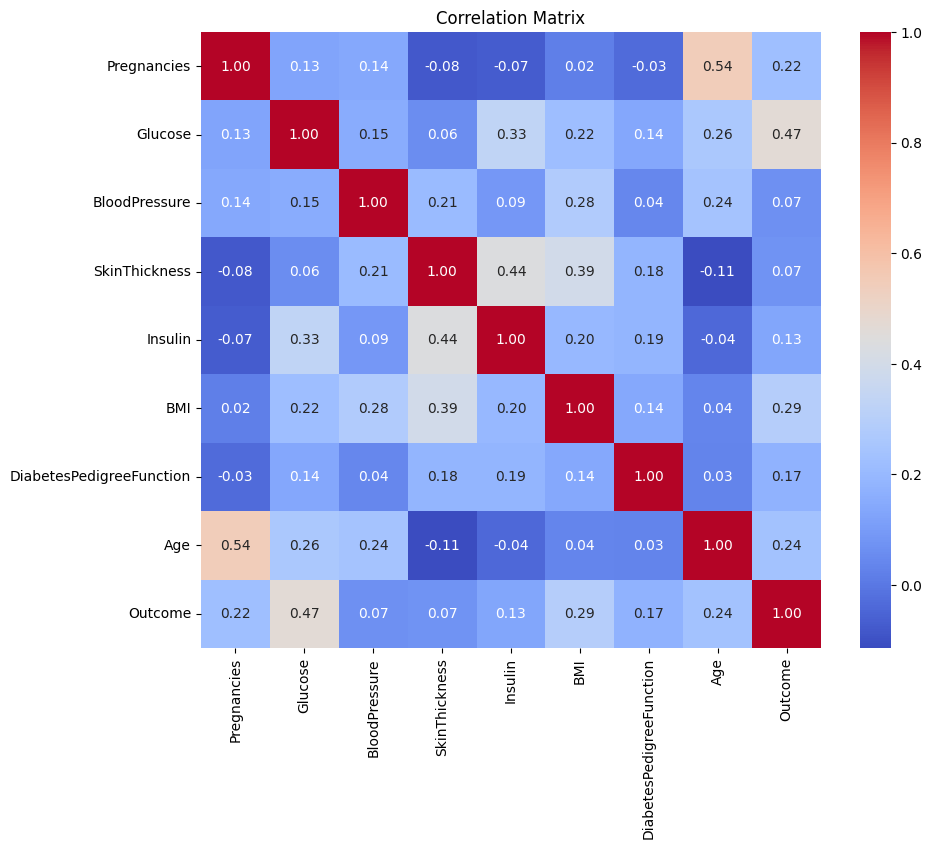

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


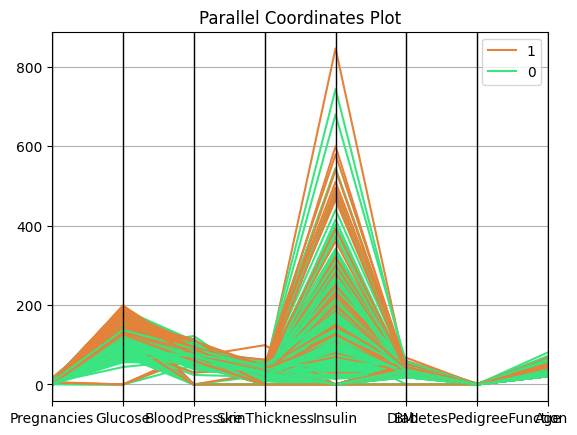

In [5]:
# Split dataset
X = df.drop(columns="Outcome")
y = df["Outcome"]

# Parallel coordinates plot
total_data = df.copy()
pd.plotting.parallel_coordinates(total_data, "Outcome", color=("#E58139", "#39E581", "#8139E5"))
plt.title("Parallel Coordinates Plot")
plt.title("Parallel Coordinates Plot")
plt.show()


In [6]:
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

select_k_best = SelectKBest(k=8)
select_k_best.fit_transform(X_train, y_train)

selected_columns = X.columns[select_k_best.get_support()]
X_train_selected = pd.DataFrame(select_k_best.transform(X_train), columns=selected_columns)
X_test_selected = pd.DataFrame(select_k_best.transform(X_test), columns=selected_columns)

X_train_selected.to_csv("../data/processed/X_train_ts_02_rs_42.csv")
X_test_selected.to_csv("../data/processed/X_test_ts_02_rs_42.csv")
y_train.to_csv("../data/processed/y_train_ts_02_rs_42.csv")
y_test.to_csv("../data/processed/y_test_ts_02_rs_42.csv")

X_train_selected.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,2.0,84.0,0.0,0.0,0.0,0.0,0.304,21.0
1,9.0,112.0,82.0,24.0,0.0,28.2,1.282,50.0
2,1.0,139.0,46.0,19.0,83.0,28.7,0.654,22.0
3,0.0,161.0,50.0,0.0,0.0,21.9,0.254,65.0
4,6.0,134.0,80.0,37.0,370.0,46.2,0.238,46.0


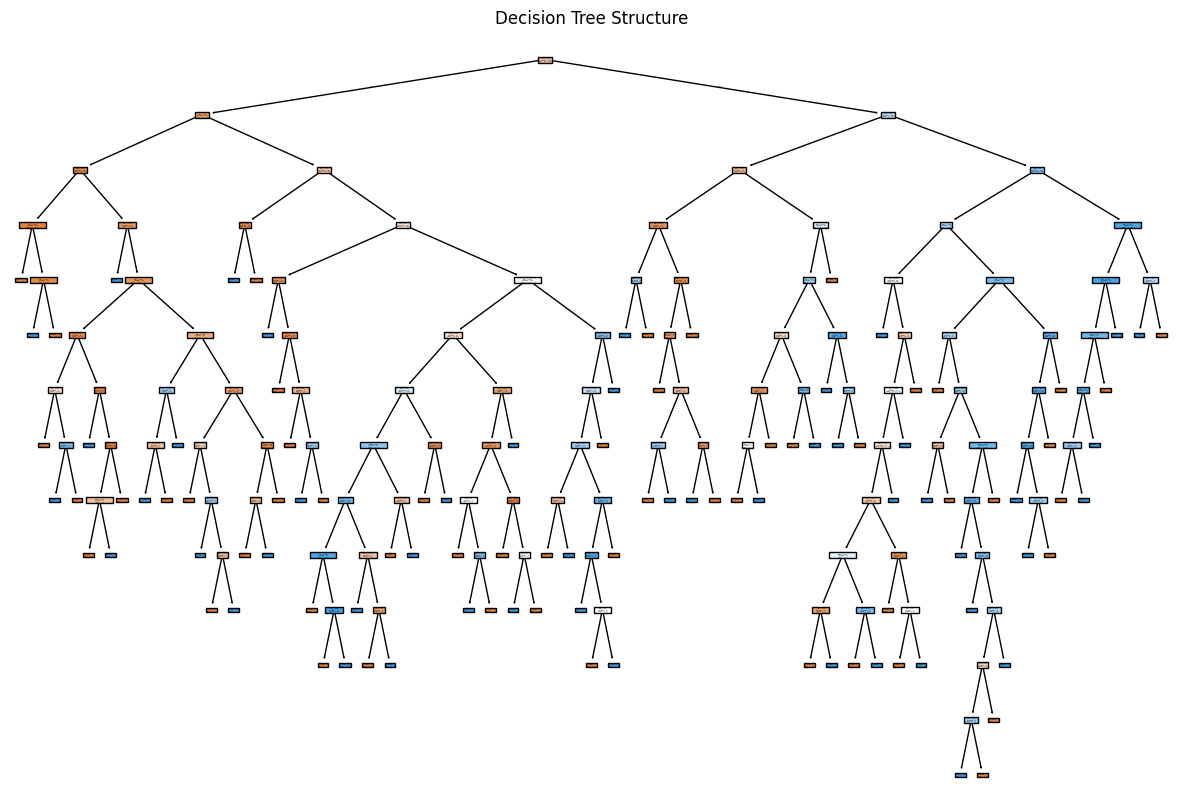

In [7]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
# Train Decision Tree Model
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train_selected, y_train)

# Plot decision tree
plt.figure(figsize=(15, 10))
tree.plot_tree(model, feature_names=X_train_selected.columns, filled=True)
plt.title("Decision Tree Structure")
plt.show()


In [8]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Evaluate model
y_pred = model.predict(X_test)
print("\nModel Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Model Accuracy: 0.7467532467532467

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.76      0.79        99
           1       0.62      0.73      0.67        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154


Confusion Matrix:
 [[75 24]
 [15 40]]



Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 2}


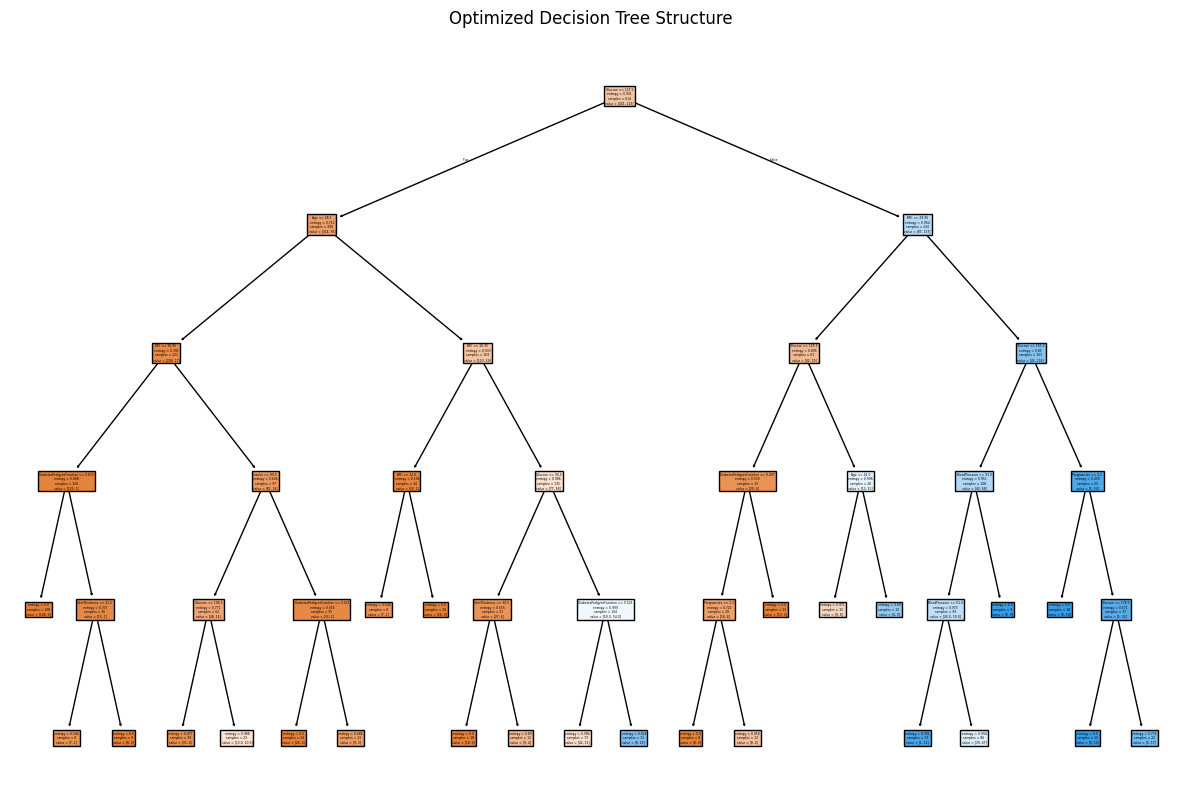

In [9]:
# Hyperparameter tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV


param_grid = {
    "max_depth": [3, 5, 10, 15, None],
    "min_samples_split": [2, 5, 10, 15],
    "min_samples_leaf": [1, 2, 4, 8],
    "criterion": ["gini", "entropy"]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=10, scoring="accuracy")
grid_search.fit(X_train_selected, y_train)

print("\nBest Parameters:", grid_search.best_params_)

best_model = DecisionTreeClassifier(random_state=42, **grid_search.best_params_)
best_model.fit(X_train_selected, y_train)

# Plot optimized decision tree
plt.figure(figsize=(15, 10))
tree.plot_tree(best_model, feature_names=X_train_selected.columns, filled=True)
plt.title("Optimized Decision Tree Structure")
plt.show()

In [ ]:
from joblib import dump
# Evaluate optimized model
y_pred = best_model.predict(X_test)

print("\nOptimized Model")
print("\nModel Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

dump(best_model, "../data/processed/model_dt_entropy_d5_l8_s2.sav")



Optimized Model

Model Accuracy: 0.7727272727272727

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.83      0.82        99
           1       0.69      0.67      0.68        55

    accuracy                           0.77       154
   macro avg       0.75      0.75      0.75       154
weighted avg       0.77      0.77      0.77       154


Confusion Matrix:
 [[82 17]
 [18 37]]


FileNotFoundError: [Errno 2] No such file or directory: './data/processed/model_dt_entropy_d5_l8_s2.sav'